In [1]:
import itertools
import os

from collections import defaultdict
from pathlib import Path

import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt

In [2]:
import utils

In [3]:
csv_location = Path('forest_fire_with_climate.csv')

In [20]:
figure_dir = Path('figures')
save_formats = [
    'png',
    'pdf',
    # 'svg', # too many data points will make the file too large
    'jpg',
]

In [4]:
df = pd.read_csv(csv_location, index_col='Unnamed: 0')

Convert `Fire_Date` to datetime object

In [5]:
df.Fire_Date = pd.to_datetime(df.Fire_Date)

Convert `DISCOVERY_TIME` to time object.

In [6]:
def convert_time_as_int_to_str(time_as_int):
    if not np.isfinite(time_as_int):
        return np.nan

    hour = int(time_as_int//100)
    miniute = int(time_as_int%100)
    return f'{hour}:{miniute}'

df.DISCOVERY_TIME = pd.to_datetime(
    df.DISCOVERY_TIME.apply(convert_time_as_int_to_str),
    format='%H:%M'
)

df.CONT_TIME = pd.to_datetime(
    df.CONT_TIME.apply(convert_time_as_int_to_str),
    format='%H:%M'
)

# use use the datetime versions of the object to calculate things as
# time delta objects
time_diff = df.DISCOVERY_TIME - df.CONT_TIME
time_diff[time_diff < np.timedelta64(0)] += np.timedelta64(1,'D')
frac_num_days = time_diff /  np.timedelta64(1,'D')

df.Days_to_extinguish_fire += frac_num_days

# remove the date part and only have time
df.DISCOVERY_TIME = df.DISCOVERY_TIME.dt.time
df.CONT_TIME = df.CONT_TIME.dt.time


df_days = df.drop(columns=['DISCOVERY_TIME','CONT_TIME'])
df_days.Days_to_extinguish_fire = df.Days_to_extinguish_fire

We remove the index column

In [7]:
df = df[[cname for cname in df.columns if cname != 'index']]

In [8]:
df

,FIRE_YEAR,Fire_Date,DISCOVERY_TIME,STAT_CAUSE_DESCR,Days_to_extinguish_fire,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,...,tmax,tmax-7,tmin,tmin-7,tdmean,tdmean-7,vpdmin,vpdmin-7,vpdmax,vpdmax-7
0,2004,2004-05-12,08:45:00,Lightning,0.718750,15:30:00,0.25,A,38.933056,-120.404444,...,19.882000,15.443715,8.381,3.559000,-2.044,-1.374000,5.451,2.063715,17.632999,12.678000
1,2004,2004-06-28,16:00:00,Lightning,5.083333,14:00:00,0.10,A,38.559167,-119.913333,...,22.945999,22.963715,5.431,6.212429,-2.837,-2.422428,4.824,5.121143,23.013000,22.866573
2,2004,2004-06-28,16:00:00,Lightning,5.166667,12:00:00,0.10,A,38.559167,-119.933056,...,22.945999,22.963715,5.431,6.212429,-2.837,-2.422428,4.824,5.121143,23.013000,22.866573
3,2004,2004-06-30,18:00:00,Lightning,1.083333,16:00:00,0.10,A,38.635278,-120.103611,...,20.254999,18.632429,7.985,6.914857,0.290,-0.571857,5.021,4.411714,17.228001,15.297143
4,2004,2004-07-01,18:00:00,Lightning,1.166667,14:00:00,0.10,A,38.688333,-120.153333,...,24.375999,23.623569,8.078,7.132000,1.546,1.577143,4.900,3.987714,22.320999,21.595142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278463,2010,2010-07-26,14:44:00,Lightning,1.036806,13:51:00,81.00,C,41.508867,-120.819167,...,31.292999,32.303143,11.516,13.050858,-0.111,2.045000,6.537,7.734286,39.761002,42.106289
278464,2010,2010-07-27,18:17:00,Lightning,NaN,NaT,1.00,B,41.684917,-122.716183,...,32.523998,33.561287,15.326,16.937572,4.183,7.629286,9.869,9.395000,41.014000,41.998859
278465,2015,2015-08-06,12:04:00,Lightning,0.686806,19:35:00,0.50,B,39.655817,-121.234567,...,36.076000,31.105860,21.862,18.520285,4.184,7.996857,18.590,9.995000,51.481998,35.001999
278466,2015,2015-06-26,17:52:00,Lightning,0.901389,20:14:00,0.05,A,40.443000,-120.664433,...,27.584000,29.078714,9.428,10.377000,-2.418,-0.871571,6.119,6.983714,32.063999,35.629711


Create the month of the fire as a feature and code the class code A-G to a number 1-7

In [9]:
df['FIRE_MONTH'] = df.Fire_Date.dt.month

df.FIRE_SIZE_CLASS = pd.Categorical(df.FIRE_SIZE_CLASS)
# df['FIRE_SIZE_CLASS_CODES'] = df.FIRE_SIZE_CLASS.cat.codes

We grab the numeric columns and remove rows containing NaNs

In [10]:
numeric_cols = [
    colname
    for colname in df.describe().columns
    if colname not in ['DISCOVERY_TIME', 'CONT_TIME']
]
nonnumeric_interested_cols = [
    'FIRE_SIZE_CLASS',
]

interested_cols = [
    *numeric_cols,
    *nonnumeric_interested_cols,
]

df_cleaned = df[interested_cols].dropna()
no_nan_entries = df[interested_cols].notna()
no_nan_rows = no_nan_entries.all(axis=1)
classes_cleaned = df[interested_cols][no_nan_rows]

We normalize the dataset

In [11]:
classes_cleaned = df_days.FIRE_SIZE_CLASS[no_nan_rows]

In [12]:
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

Another interesting question is whether the number of days to put out a fire can be predicted. Consider linear regression as a starting point.

In [13]:
from sklearn.linear_model import LinearRegression

df_lr = df_cleaned[numeric_cols].drop('Days_to_extinguish_fire', axis=1)

X_lr_train, X_lr_test, y_lr_train, y_lr_test = train_test_split(df_lr, df_cleaned.Days_to_extinguish_fire, test_size=0.1)


lin_reg = make_pipeline(
    StandardScaler(),
    LinearRegression(fit_intercept=False),
).fit(X_lr_train, y_lr_train)

y_lr = lin_reg.predict(X_lr_test)
residual = abs(y_lr - y_lr_test)
lr_accuracy = sum( abs(residual)  )/len(y_lr)
msqr_err = np.mean(np.square(y_lr - y_lr_test))
display(msqr_err)
display(msqr_err / y_lr_train.var())

# Note that the pipeline score calls the score of the final estimator which in this case is LinearRegression.score
# https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline.score
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.score
display(lin_reg.score(X_lr_test, y_lr_test))

158.41973653604924

1.0144834835111023

-0.07039415991684361

Try Best Subset Selection

In [14]:
len(df_lr.columns)

20

In [15]:
df_lr.columns

Index(['FIRE_YEAR', 'FIRE_SIZE', 'LATITUDE', 'LONGITUDE', 'FIPS_CODE', 'ppt',
       'ppt-7', 'tmean', 'tmean-7', 'tmax', 'tmax-7', 'tmin', 'tmin-7',
       'tdmean', 'tdmean-7', 'vpdmin', 'vpdmin-7', 'vpdmax', 'vpdmax-7',
       'FIRE_MONTH'],
      dtype='object')

In [16]:
p = len(df_lr.columns)

df_bss = pd.DataFrame(
    data=[], 
    index=['Intercept', *df_lr.columns],
    columns=[f'k={ii}' for ii in range(1, p+1)],
)

score_by_size = defaultdict(list)
rss_vectors = defaultdict(list)


for k in range(1, p+1):

    best_score = -float('inf')
    best_coef_vec = None
    best_subset_cols = None

    for subset_cols in itertools.combinations(df_lr.columns, k):
        # we have to do some odd stuff when there is only 1
        if k==1:
            # pandas doesn't like to take in a list of size of one of column names
            subset_cols = subset_cols[0]
        else:
            # pandas also doesn't like tuples when accessing multiple columns and wants a list
            subset_cols = list(subset_cols)

        subset_x_train = X_lr_train[subset_cols]
        subset_x_test = X_lr_test[subset_cols]
            
        if k==1:
            # sklearn needs 2D arrays
            subset_x_train = subset_x_train.to_numpy().reshape(-1, 1)
            subset_x_test = subset_x_test.to_numpy().reshape(-1, 1)
        
        lin_reg_bss = make_pipeline(
            StandardScaler(),
            LinearRegression(fit_intercept=True),
        ).fit(subset_x_train, y_lr_train)

        # this is after the data transformation
        linear_model = lin_reg_bss.steps[-1][1]
        
        score = lin_reg_bss.score(subset_x_test, y_lr_test)
        score_by_size[k].append(score)
        rss_vectors[k].append(
            mean_squared_error(
                y_true=y_lr_test,
                y_pred=lin_reg_bss.predict(subset_x_test),
            ),
        )

        if best_score < score:
            best_score = score
            best_subset_cols = subset_cols
            best_coef_vec = np.array([
                linear_model.intercept_,
                *linear_model.coef_,
            ])

    result_cols = ['Intercept']

    if k==1:
        result_cols.append(best_subset_cols)
    else:
        result_cols.extend(best_subset_cols)
    
    df_bss.loc[result_cols, f'k={k}'] = best_coef_vec

In [17]:
display(df_bss.replace({ np.nan: '' }))

,k=1,k=2,k=3,k=4,k=5,k=6,k=7,k=8,k=9,k=10,k=11,k=12,k=13,k=14,k=15,k=16,k=17,k=18,k=19,k=20
Intercept,4.032284,4.032284,4.032284,4.032284,4.032284,4.032284,4.032284,4.032284,4.032284,4.032284,4.032284,4.032284,4.032284,4.032284,4.032284,4.032284,4.032284,4.032284,4.032284,4.032284
FIRE_YEAR,,,,,,0.193011,0.180233,0.178716,0.1767,0.168817,0.167285,0.166915,0.166994,0.208056,0.207331,0.206664,0.207866,0.216018,0.215753,0.212203
FIRE_SIZE,2.053584,2.035561,2.032664,2.052565,2.046378,2.046665,2.04536,2.049584,2.04956,2.049587,2.048944,2.049102,2.049093,2.047582,2.047406,2.047397,2.047749,2.045585,2.045879,2.046725
LATITUDE,,1.268497,1.183804,0.957162,0.967562,0.979194,0.974692,0.911391,0.904618,0.918301,0.929446,0.930335,0.929083,0.88802,0.887197,0.884577,0.885748,0.934951,0.936209,0.942548
LONGITUDE,,,-0.176092,-0.431347,-0.363228,-0.365154,-0.40763,-0.443989,-0.451089,-0.455584,-0.47282,-0.47137,-0.471273,-0.374623,-0.375677,-0.375562,-0.372044,-0.376434,-0.377701,-0.381579
FIPS_CODE,,,,,,,0.149866,0.179516,0.178215,0.175084,0.174893,0.174754,0.174347,0.19519,0.193708,0.192886,0.193132,0.198247,0.198041,0.200565
ppt,,,,,,,,,,,,-0.036076,-0.037634,-0.046389,-0.050562,-0.043121,-0.029697,-0.027955,-0.029661,-0.031595
ppt-7,,,,,,,,-0.103296,-0.085404,-0.094317,-0.090373,-0.073692,-0.072226,,,-0.020519,-0.034849,-0.016115,-0.015612,-0.010754
tmean,,,,,,,,,,,,,,,,,-1017.069382,-1011.454659,-1009.268035,-937.803737
tmean-7,,,,,,,,,,,,,,2805.745291,2809.641132,2808.512742,3737.006156,3900.811393,3908.874672,3824.193235


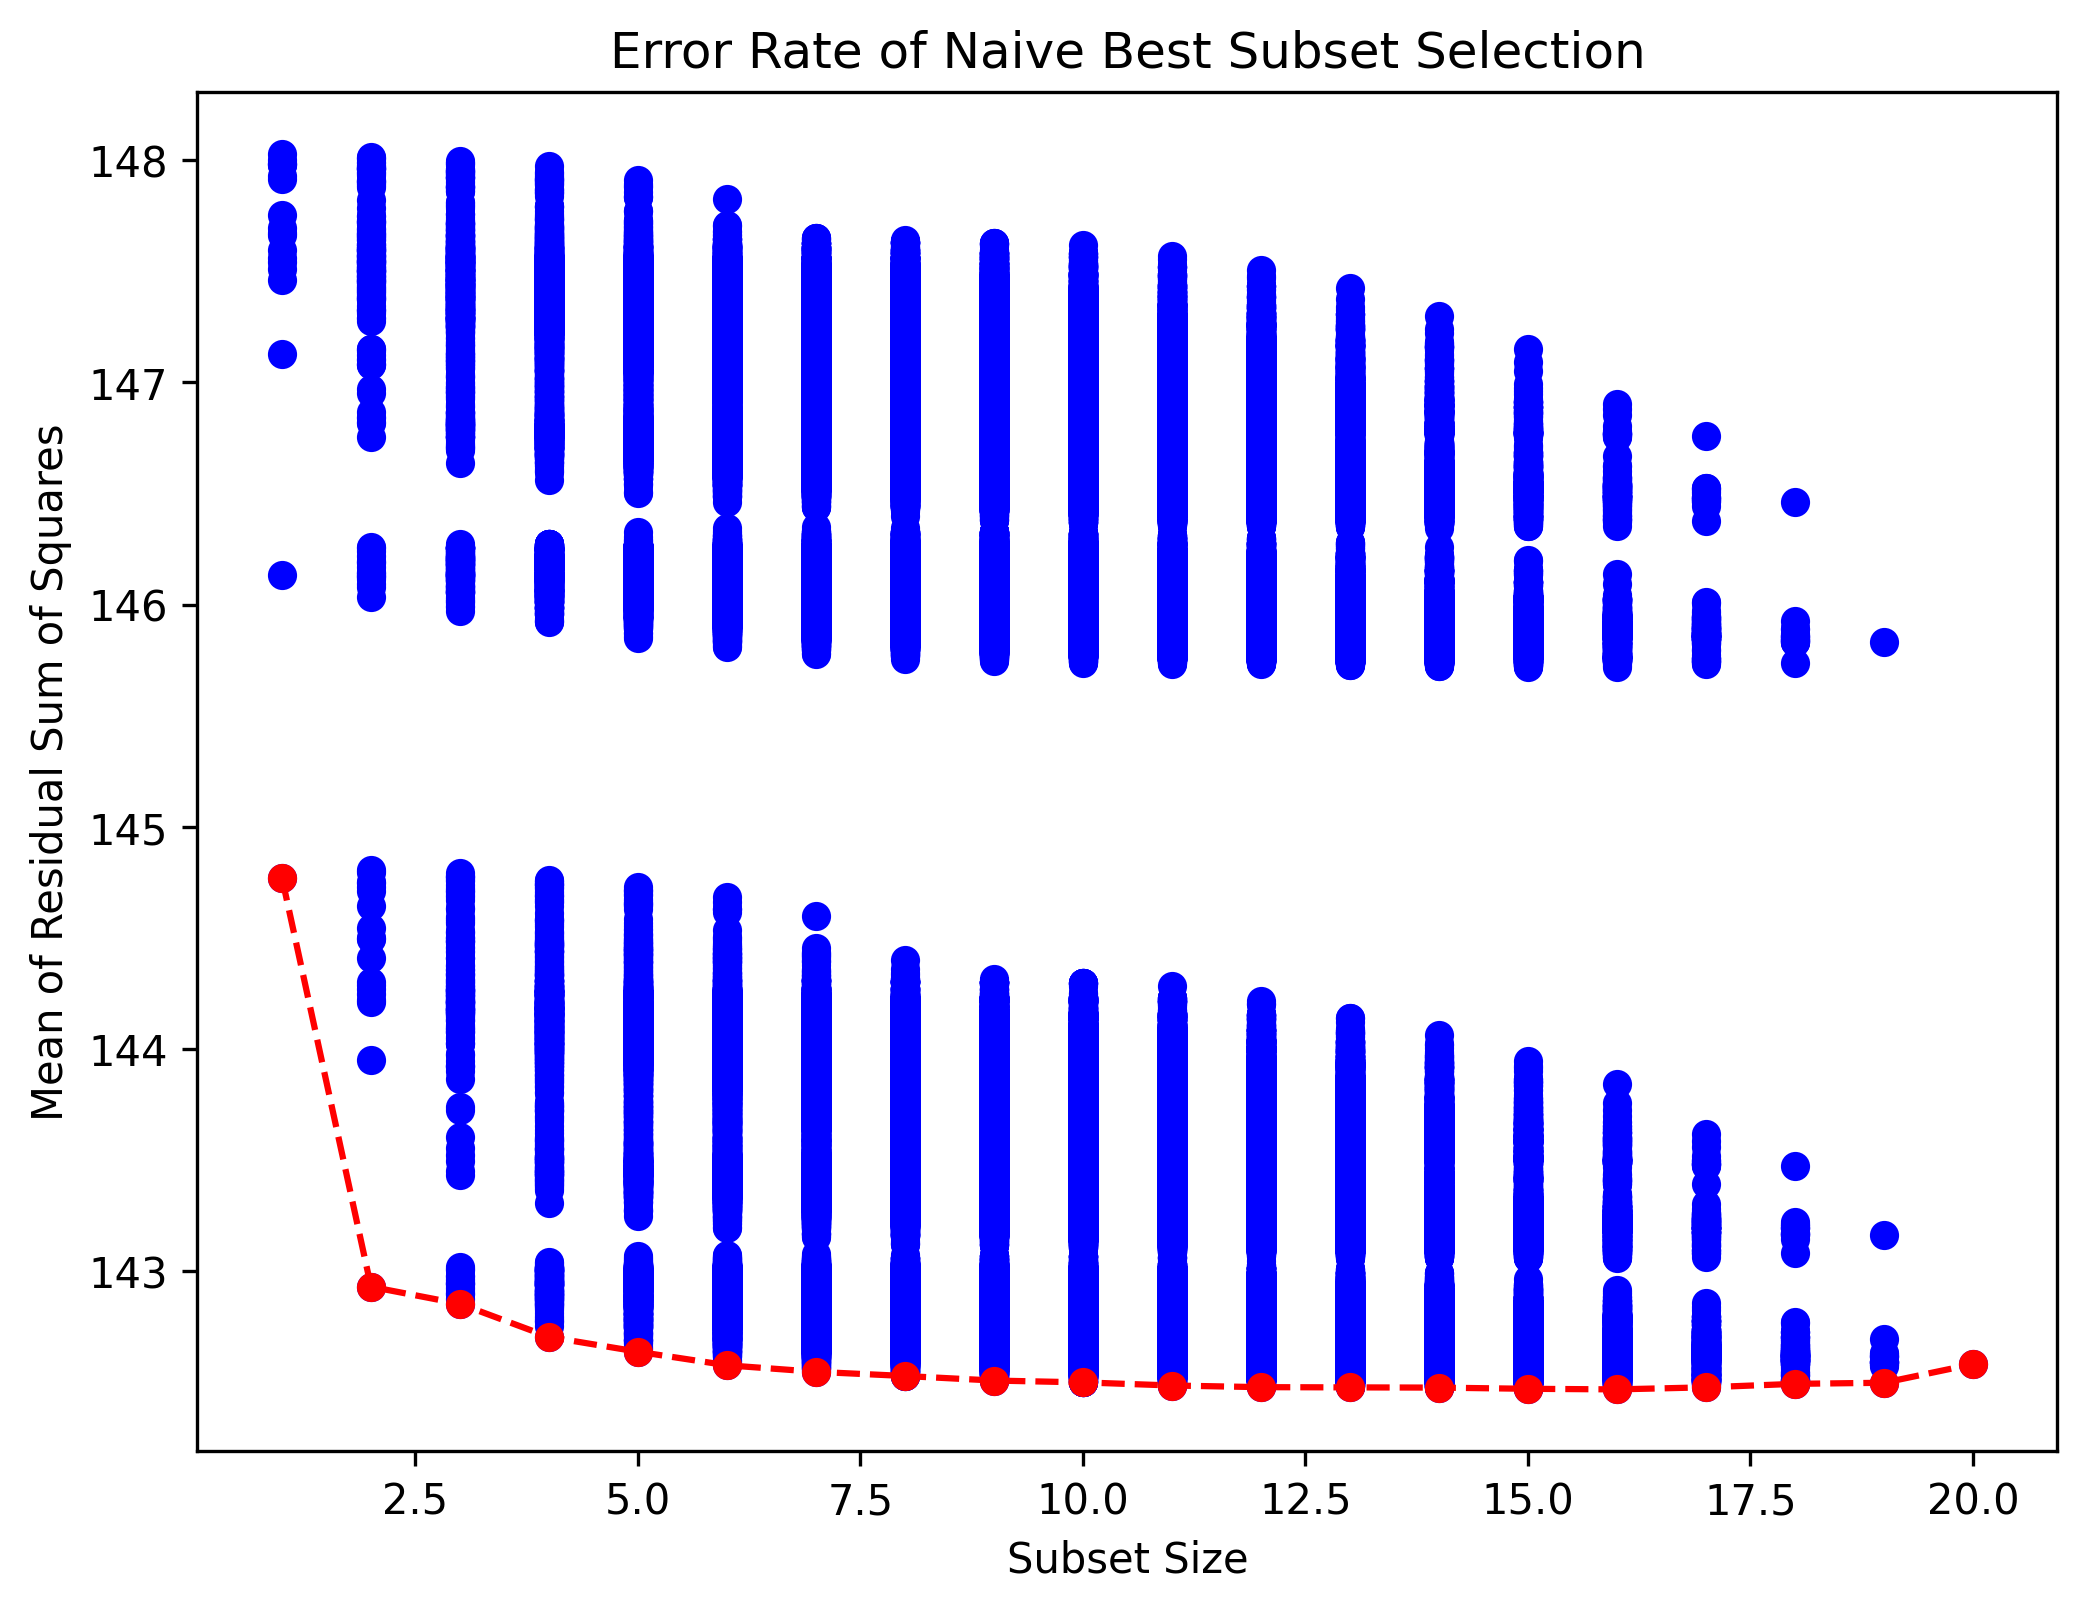

In [22]:
fig2, ax2 = plt.subplots(
    figsize=(8,6),
    dpi=300,
)

for k, rss_vec in sorted(rss_vectors.items()):
    ax2.plot(
        [k for _ in rss_vec],
        rss_vec,
        'bo',
    )

ax2.plot(
    *zip(*[
        (k, min(rss_vec))
        for k,rss_vec in sorted(rss_vectors.items())
        if len(rss_vec) > 0
    ]),
# The above tecnically does the same thing as the commented out code below
# but is more saver since any empty entry won't be displayed.
# But is a bit hard to read if one is unfamiliar with the star operator in arugnment unpacking
#     range(1,p+1),
#     [
#         min(rss_vectors[k])
#         for k in range(1,p+1)
#     ],
    'r--o'
)

ax2.set_ylabel('Mean of Residual Sum of Squares')
ax2.set_xlabel('Subset Size')
ax2.set_title('Error Rate of Naive Best Subset Selection')

for ext in save_formats:
    fig2.savefig(figure_dir / f'naive_bss_mssr.{ext}')


plt.show()


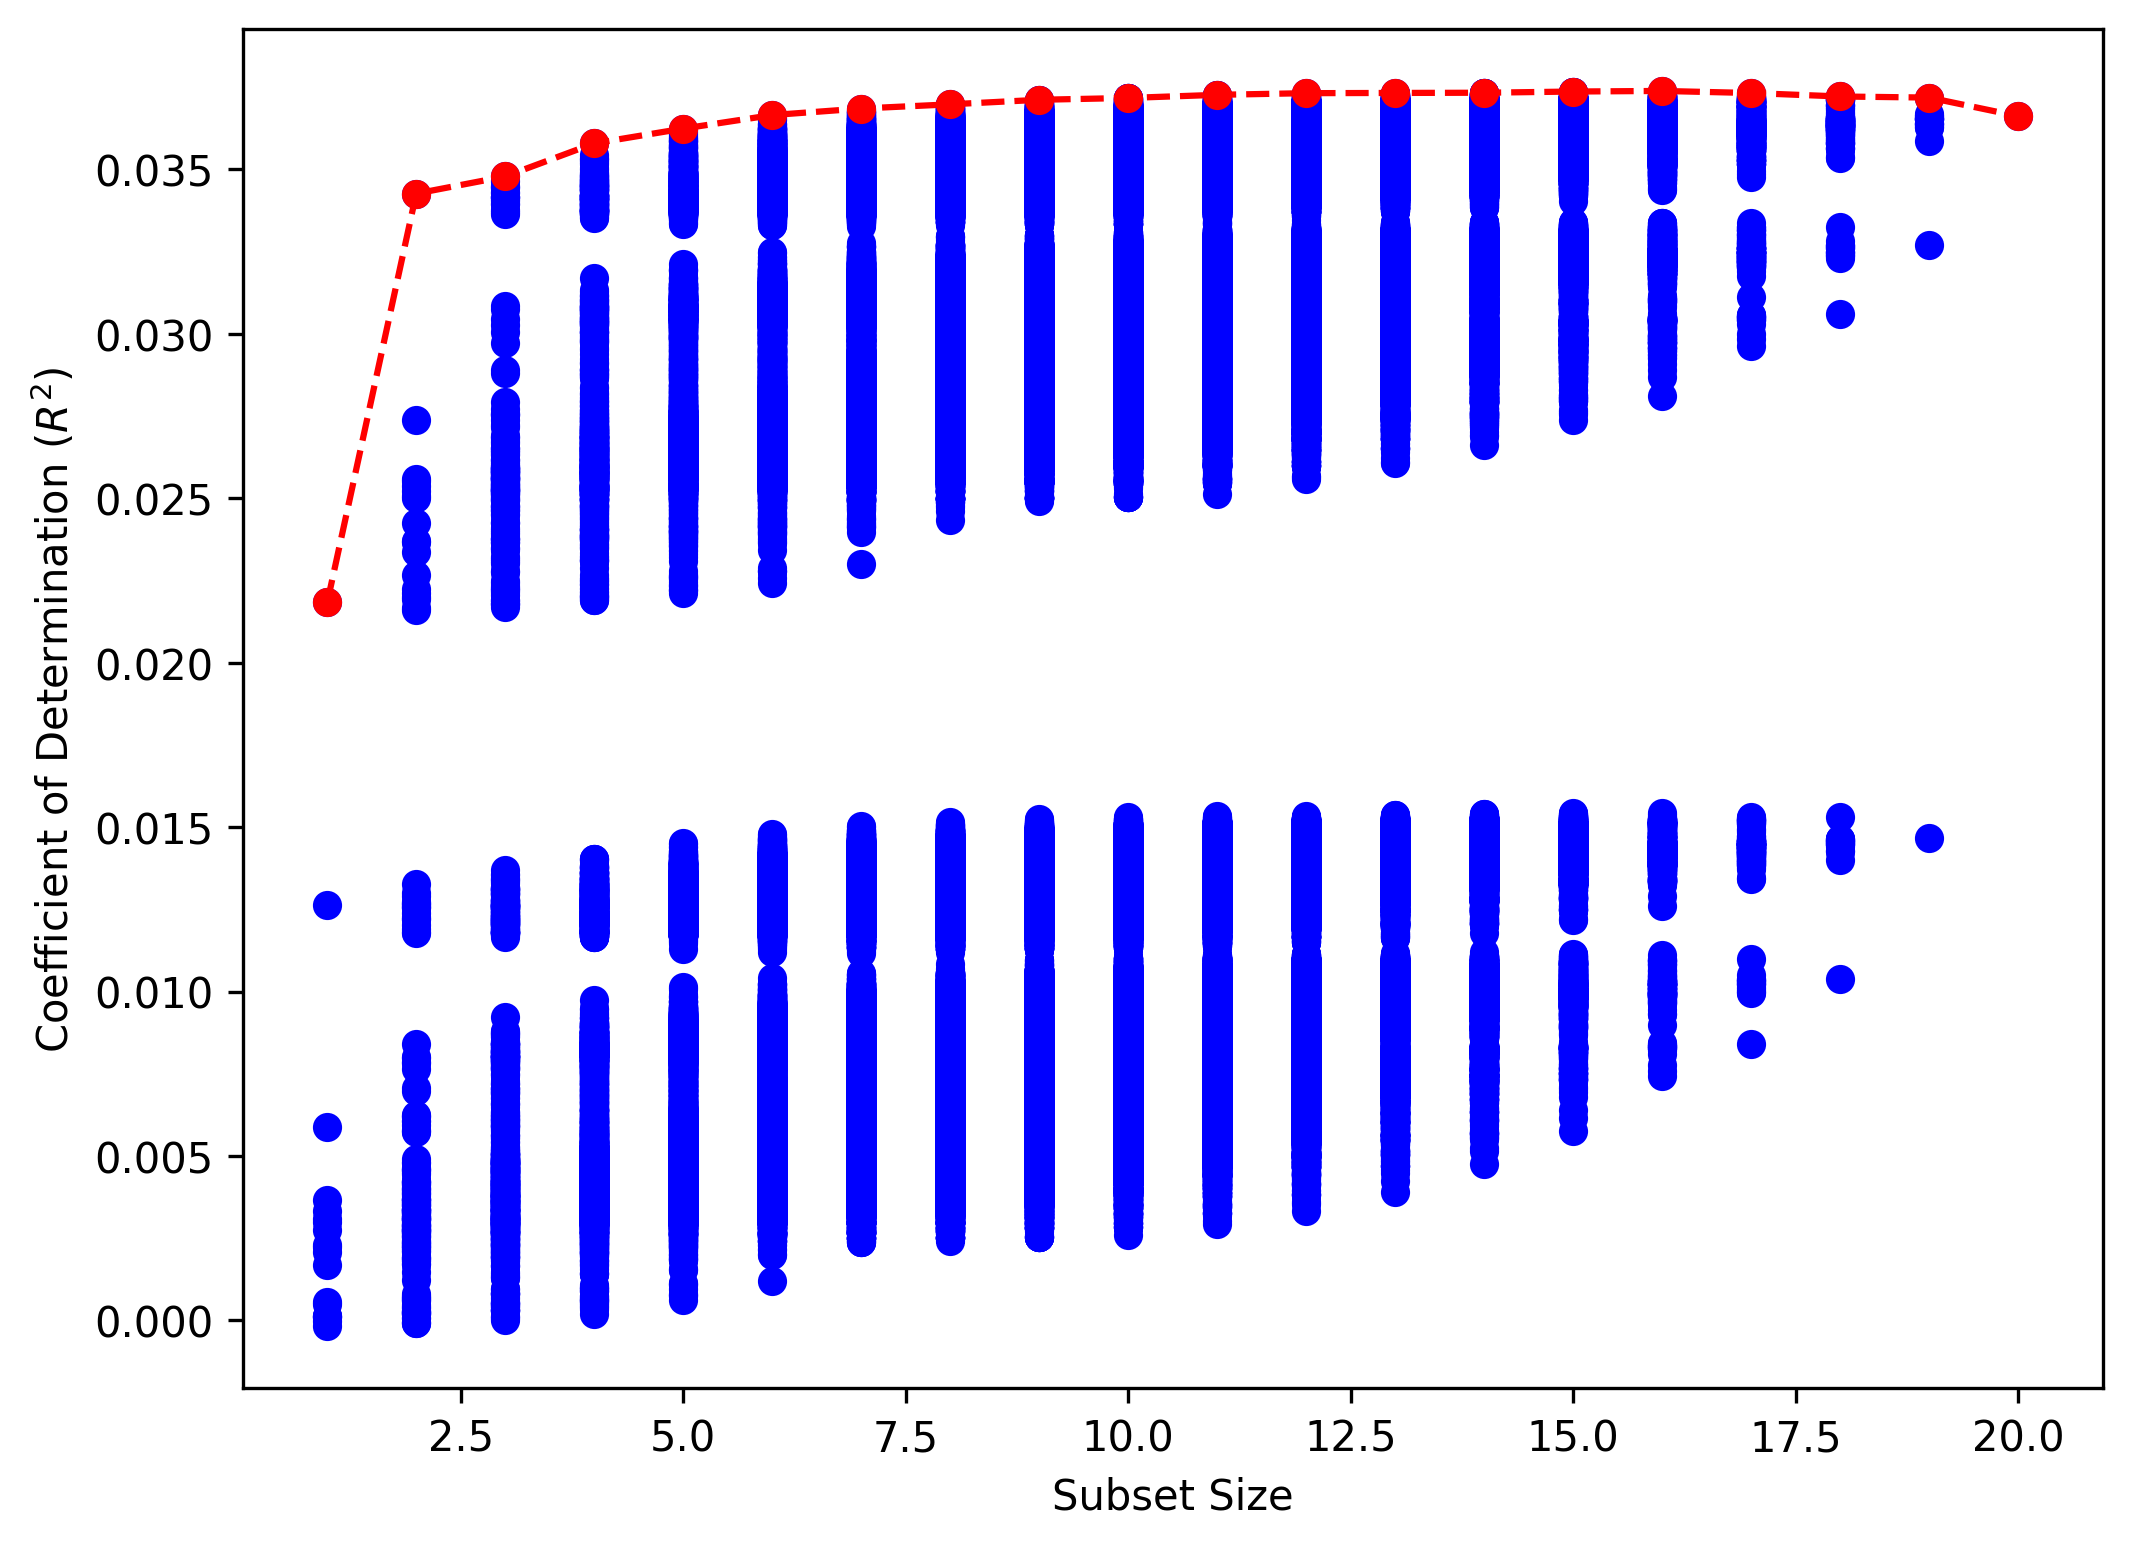

In [24]:
fig3, ax3 = plt.subplots(
    figsize=(8,6),
    dpi=300,
)

for k, score_list in sorted(score_by_size.items()):
    ax3.plot(
        [k for _ in score_list],
        score_list,
        'bo',
    )

ax3.plot(
    *zip(*[
        (k, max(score_list))
        for k,score_list in sorted(score_by_size.items())
        if len(score_list) > 0
    ]),
    'r--o'
)

ax3.set_ylabel(r'Coefficient of Determination ($R^{2}$)')
ax3.set_xlabel('Subset Size')

ax2.set_title(r'Naive Best Subset Selection')

for ext in save_formats:
    fig3.savefig(figure_dir / f'naive_bss_r2.{ext}')


plt.show()